https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


%matplotlib inline

#ggplot 스타일은 격자로 숫자범위가 나타남
plt.style.use('ggplot')

#그래프에서 마이너스 폰트가 깨지는 문제 대처
mpl.rcParams['axes.unicode_minus']=False

## 1. 데이터 로드

In [2]:
train = pd.read_csv('train.csv', parse_dates=['key'], nrows = 2_000_000)
test=pd.read_csv('test.csv', parse_dates=['key'])
sample = pd.read_csv('sample_submission.csv')
## key(날짜) 자료형이 object -> datetime으로 변환

## + Sampling 4%

In [158]:
train_sample = train.iloc[0:2000000]

## 2. 전처리

In [159]:
train_sample.head(1)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1


In [160]:
test.head(2)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,dayofweek,abs_diff_longitude,abs_diff_latitude,latitude_m,longitude_m,distance,distance_km
0,2015-01-27 13:08:24.000000200,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,13,1,0.008110,0.019970,2289.353943,713.684082,2398.01719,2.398017
1,2015-01-27 13:08:24.000000300,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,13,1,0.012024,0.019817,2271.861267,1058.105469,2506.18052,2.506181


In [161]:
sample.head(2)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.189027
1,2015-01-27 13:08:24.0000003,10.823495


In [162]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 8 columns):
key                  datetime64[ns]
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 122.1+ MB


## [2-1] 결측치(Null) 확인

In [163]:
train_sample.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
passenger_count       0
dtype: int64

In [164]:
train_sample.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
passenger_count       0
dtype: int64

## [2-2] 결측치(Null) 제거 및 인덱스 정렬

In [165]:
len(train_sample)

2000000

In [166]:
train_sample.tail(1)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
1999999,2010-01-16 15:46:00.000000153,12.9,2010-01-16 15:46:00 UTC,-73.95514,40.779382,-73.914775,40.820602,2


In [167]:
train_sample.dropna(inplace = True)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [168]:
train_sample.reset_index(drop = True, inplace=True)

In [169]:
train_sample.tail(1)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
1999985,2010-01-16 15:46:00.000000153,12.9,2010-01-16 15:46:00 UTC,-73.95514,40.779382,-73.914775,40.820602,2


## [2-3] 이상치 확인 // 제거 :train, test 둘 다 // ★row 삭제 후 '인덱스 정렬'

### fare_amount 이상치

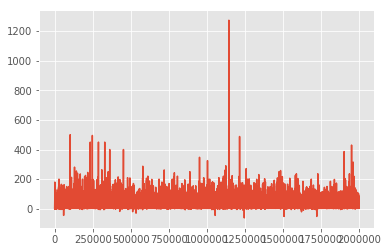

In [170]:
train_sample['fare_amount'].plot()

In [171]:
train_sample= train_sample[train_sample['fare_amount'] > 0]
train_sample= train_sample[train_sample['fare_amount'] < 600]

In [172]:
# train_sample= train_sample[train_sample['fare_amount'] < 300]

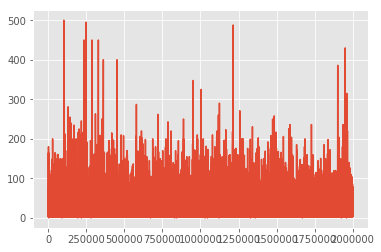

In [173]:
train_sample['fare_amount'].plot()

In [174]:
train_sample['fare_amount'].min()

0.01

### 승객 수 이상치 확인

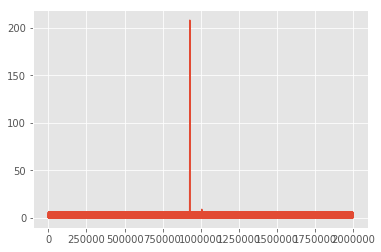

In [175]:
train_sample['passenger_count'].plot()

(array([0.000000e+00, 7.109000e+03, 1.383093e+06, 2.958640e+05,
        8.764800e+04, 4.264900e+04, 1.414860e+05, 4.200100e+04,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00]),
 array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19]),
 <a list of 20 Patch objects>)

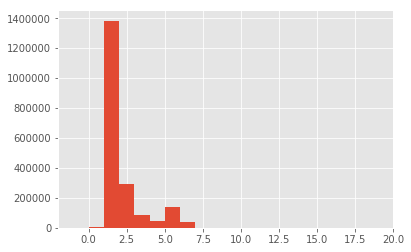

In [176]:
plt.hist(train_sample['passenger_count'], bins = np.arange(-1, 20, 1))

In [177]:
train_sample['passenger_count'].max()

208

In [178]:
train_sample['passenger_count'].value_counts()

1      1383093
2       295864
5       141486
3        87648
4        42649
6        42001
0         7109
208          1
9            1
Name: passenger_count, dtype: int64

In [179]:
train_sample= train_sample[train_sample['passenger_count'] != 0]
train_sample= train_sample[train_sample['passenger_count'] < 10]

In [180]:
train_sample['passenger_count'].value_counts()

1    1383093
2     295864
5     141486
3      87648
4      42649
6      42001
9          1
Name: passenger_count, dtype: int64

### 위도 경도 이상치

(array([5.000000e+00, 6.000000e+00, 1.953795e+06, 1.300000e+01,
        3.000000e+00, 2.000000e+00, 0.000000e+00, 1.000000e+00,
        1.000000e+00, 2.790000e+02, 3.763600e+04, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 9.580000e+02, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00]),
 array([-100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,
          10,   20,   30,   40,   50,   60,   70,   80,   90]),
 <a list of 19 Patch objects>)

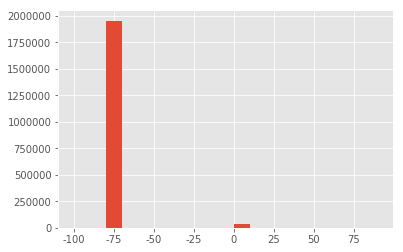

In [181]:
plt.hist(train_sample['pickup_longitude'], bins = np.arange(-100, 100, 10))

In [182]:
train_sample = train_sample[train_sample['pickup_longitude'] < -50]

(array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00, 0.000000e+00, 5.700000e+01, 0.000000e+00,
        0.000000e+00, 2.490000e+02, 1.953523e+06, 2.000000e+00,
        2.000000e+00, 0.000000e+00, 0.000000e+00]),
 array([-100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,
          10,   20,   30,   40,   50,   60,   70,   80,   90]),
 <a list of 19 Patch objects>)

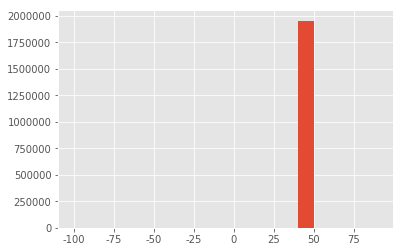

In [183]:
plt.hist(train_sample['pickup_latitude'], bins = np.arange(-100, 100, 10))

(array([2.000000e+00, 6.000000e+00, 1.952006e+06, 1.000000e+01,
        5.000000e+00, 2.000000e+00, 2.000000e+00, 0.000000e+00,
        0.000000e+00, 1.320000e+02, 1.660000e+03, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00]),
 array([-100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,
          10,   20,   30,   40,   50,   60,   70,   80,   90]),
 <a list of 19 Patch objects>)

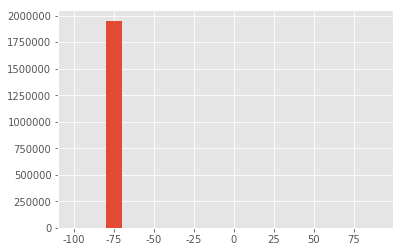

In [184]:
plt.hist(train_sample['dropoff_longitude'], bins = np.arange(-100, 100, 10))

(array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00, 2.000000e+00, 1.659000e+03, 0.000000e+00,
        1.000000e+00, 2.580000e+02, 1.951903e+06, 3.000000e+00,
        0.000000e+00, 5.000000e+00, 0.000000e+00]),
 array([-100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,
          10,   20,   30,   40,   50,   60,   70,   80,   90]),
 <a list of 19 Patch objects>)

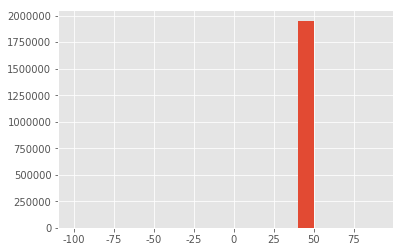

In [185]:
plt.hist(train_sample['dropoff_latitude'], bins = np.arange(-100, 100, 10))

### 인덱스 정렬

In [186]:
len(train_sample)

1953857

In [187]:
train_sample.tail(1)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
1999985,2010-01-16 15:46:00.000000153,12.9,2010-01-16 15:46:00 UTC,-73.95514,40.779382,-73.914775,40.820602,2


In [188]:
train_sample.reset_index(drop= True, inplace=True)

In [189]:
train_sample.tail(1)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
1953856,2010-01-16 15:46:00.000000153,12.9,2010-01-16 15:46:00 UTC,-73.95514,40.779382,-73.914775,40.820602,2


### test 제거 및 정렬

In [190]:
len(test)

9914

In [191]:
test['passenger_count'].max()

6

In [192]:
test['passenger_count'].min()

1

In [193]:
# test= test[test['fare_amount'] > 0]

test= test[test['passenger_count'] != 0]

test = test[test['pickup_longitude'] < -50]

test.reset_index(drop= True, inplace=True)

In [194]:
len(test)

9914

In [195]:
test.tail(1)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,dayofweek,abs_diff_longitude,abs_diff_latitude,latitude_m,longitude_m,distance,distance_km
9913,2015-01-18 14:06:23.000000600,2015-01-18 14:06:23 UTC,-73.988022,40.75407,-74.000282,40.75922,6,2015,1,18,14,6,0.01226,0.00515,590.377808,1078.918457,1229.882512,1.229883


## [2-4] datetime 분리

In [196]:
train_sample["year"]=train_sample["key"].dt.year
train_sample["month"]=train_sample["key"].dt.month
train_sample["day"]=train_sample["key"].dt.day
train_sample["hour"]=train_sample["key"].dt.hour
train_sample["dayofweek"]=train_sample["key"].dt.dayofweek # 월화수목금토일 0,1,2,3,4,5,6

In [197]:
test["year"]=test["key"].dt.year
test["month"]=test["key"].dt.month
test["day"]=test["key"].dt.day
test["hour"]=test["key"].dt.hour
test["dayofweek"]=test["key"].dt.dayofweek # 월화수목금토일 0,1,2,3,4,5,6

## [2-5] 거리 값 추가 및 데이터프레임 재생성

In [198]:
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

In [199]:
add_travel_vector_features(train_sample)

In [200]:
add_travel_vector_features(test)

In [201]:
train_sample.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,dayofweek,abs_diff_longitude,abs_diff_latitude
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0,0.002701,0.009041
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,1,0.036780,0.070701


In [202]:
#위도값 변경 X_train
latitude_m = []
for i in range(len(train_sample)):
    latitude_m.append(train_sample['abs_diff_latitude'][i] * 114640)

In [203]:
#경도값 변경 X_train
longitude_m = []
for i in range(len(train_sample)):
    longitude_m.append(train_sample['abs_diff_longitude'][i] * 88000)

In [204]:
#위도값 변경 X_test
latitude_m2 = []
for i in range(len(test)):
    latitude_m2.append(test['abs_diff_latitude'][i] * 114640)

In [205]:
#경도값 변경 X_test
longitude_m2 = []
for i in range(len(test)):
    longitude_m2.append(test['abs_diff_longitude'][i] * 88000)

In [206]:
train_sample['latitude_m'] = latitude_m
train_sample['longitude_m'] = longitude_m

test['latitude_m'] = latitude_m2
test['longitude_m'] = longitude_m2

In [207]:
train_sample.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,dayofweek,abs_diff_longitude,abs_diff_latitude,latitude_m,longitude_m
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0,0.002701,0.009041,1036.46024,237.688
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,1,0.036780,0.070701,8105.16264,3236.640


피타고라스 정리 활용 직선거리 구하기

In [208]:
import numpy as np
aa = np.square(train_sample['latitude_m']) 
bb = np.square(train_sample['longitude_m']) 
cc = aa + bb
cc[0:10]

0    1.130745e+06
1    7.616950e+07
2    2.066947e+06
3    8.332933e+06
4    4.275260e+06
5    1.540364e+07
6    2.580665e+06
7    1.866193e+07
8    1.704676e+06
9    8.655104e+06
dtype: float64

In [209]:
c = np.sqrt(cc) 
c[0:10]

0    1063.365137
1    8727.513959
2    1437.688019
3    2886.682028
4    2067.670293
5    3924.747676
6    1606.444825
7    4319.945710
8    1305.632494
9    2941.955745
dtype: float64

In [210]:
aa2 = np.square(test['latitude_m']) 
bb2 = np.square(test['longitude_m']) 
cc2 = aa2 + bb2
cc2[0:10]

0    5.750486e+06
1    6.280941e+06
2    4.084394e+05
3    4.105212e+06
4    3.095345e+07
5    1.110521e+07
6    9.417835e+05
7    5.014150e+08
8    1.602263e+07
9    1.311015e+06
dtype: float64

In [211]:
c2 = np.sqrt(cc2) 
c2[0:10]

0     2398.017190
1     2506.180520
2      639.092661
3     2026.132221
4     5563.582543
5     3332.448093
6      970.455325
7    22392.297545
8     4002.827337
9     1144.995711
dtype: float64

In [212]:
train_sample['distance'] = c

In [213]:
test['distance'] = c2

In [214]:
train_sample.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,dayofweek,abs_diff_longitude,abs_diff_latitude,latitude_m,longitude_m,distance
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0,0.002701,0.009041,1036.46024,237.688,1063.365137
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,1,0.036780,0.070701,8105.16264,3236.640,8727.513959


## [2-6] 새로운 feature 이상치 확인 / train, test 제거 / 인덱스 재정렬

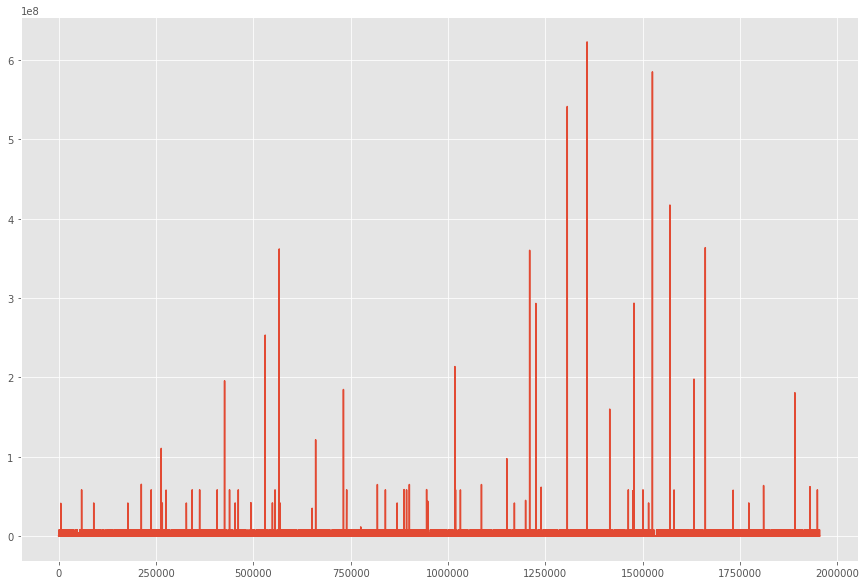

In [215]:
train_sample['distance'].plot(figsize = (15,10))

(array([    0., 25481.,  1237., ...,    49.,    43.,    55.]),
 array([  -10,     0,    10, ..., 19970, 19980, 19990]),
 <a list of 2000 Patch objects>)

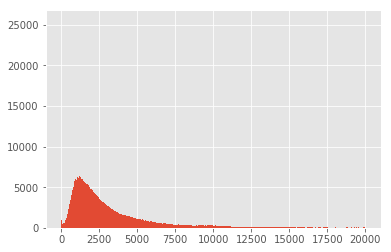

In [216]:
plt.hist(train_sample['distance'], bins = np.arange(-10, 20000, 10))

In [217]:
train_sample['distance'].max()

622598171.1292417

In [218]:
train_sample['distance'].min()

0.0

In [219]:
train_sample['distance'].describe()

count    1.953857e+06
mean     1.506660e+04
std      1.090967e+06
min      0.000000e+00
25%      1.300692e+03
50%      2.233495e+03
75%      4.064238e+03
max      6.225982e+08
Name: distance, dtype: float64

### 알아보기 힘드니 km 변환

In [220]:
train_sample['distance_km'] = train_sample['distance']/1000

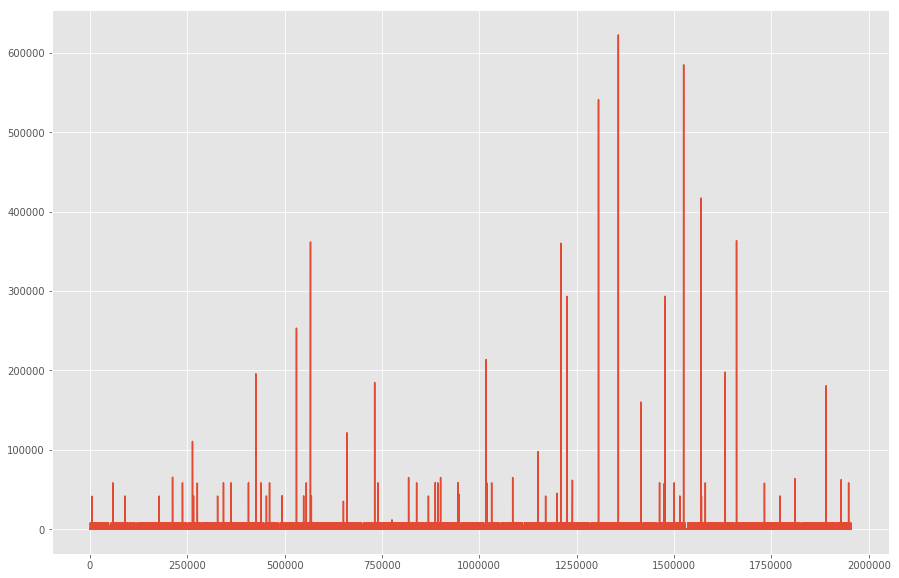

In [221]:
train_sample['distance_km'].plot(figsize = (15,10))

### 뉴욕에서 200km 이상 택시를 탈 수 없다고함!
    뉴욕 면적: 789km² ,서울 면적: 605.2km²
    상식선에서 100km 잘라보기

In [222]:
train_sample = train_sample[train_sample['distance_km'] < 25000]

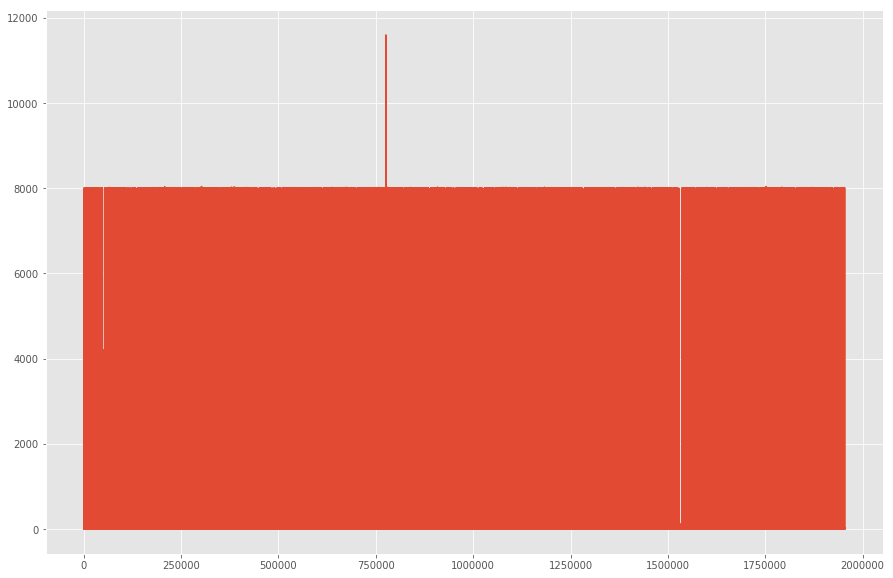

In [223]:
train_sample['distance_km'].plot(figsize = (15,10))

In [224]:
train_sample = train_sample[train_sample['distance_km'] < 105]

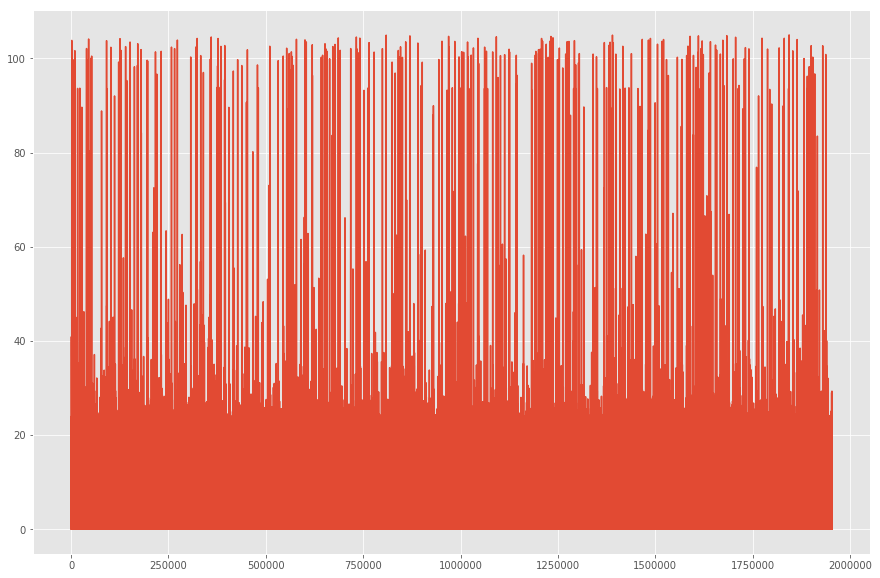

In [225]:
train_sample['distance_km'].plot(figsize = (15,10))

In [226]:
train_sample.reset_index(drop= True, inplace=True)

In [227]:
train_sample.tail(1)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,dayofweek,abs_diff_longitude,abs_diff_latitude,latitude_m,longitude_m,distance,distance_km
1951430,2010-01-16 15:46:00.000000153,12.9,2010-01-16 15:46:00 UTC,-73.95514,40.779382,-73.914775,40.820602,2,2010,1,16,15,5,0.040365,0.04122,4725.4608,3552.12,5911.644126,5.911644


In [228]:
len(train_sample)

1951431

### test 셋도 제거 및 정렬

In [229]:
len(test)

9914

In [230]:
test['distance_km'] = test['distance']/1000
len(test)

9914

In [231]:
test['distance_km'].max()

104.0283320092315

In [232]:
test = test[test['distance_km'] < 105]

test.reset_index(drop= True, inplace=True)

In [233]:
len(test)

9914

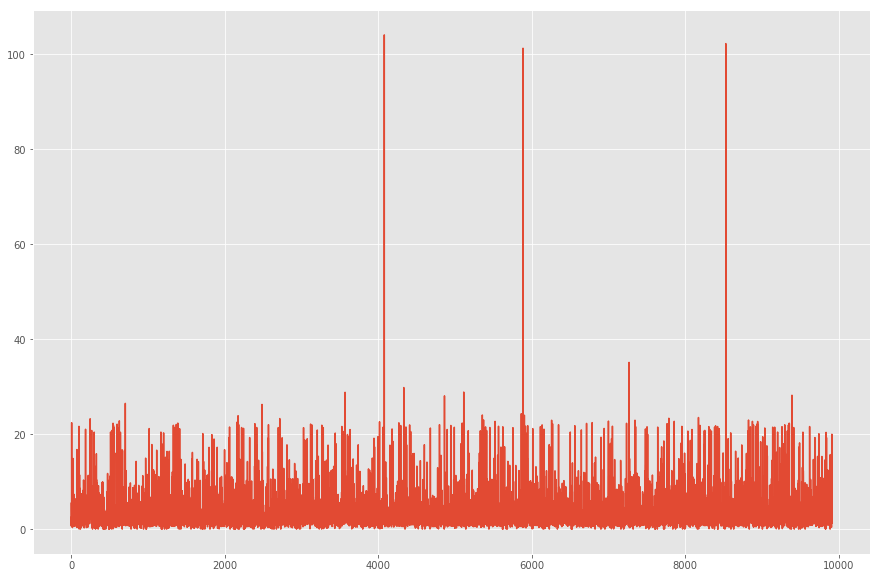

In [234]:
test['distance_km'].plot(figsize = (15,10))

## 3. 모델링

## [3-1] 셋 분리

In [235]:
train_sample.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'year', 'month', 'day', 'hour', 'dayofweek',
       'abs_diff_longitude', 'abs_diff_latitude', 'latitude_m', 'longitude_m',
       'distance', 'distance_km'],
      dtype='object')

In [236]:
X_train = train_sample[['year', 'month', 'hour', 'dayofweek', 'distance']]
X_test = test[['year', 'month', 'hour', 'dayofweek', 'distance']]

In [237]:
y_train = train_sample[['fare_amount']]
y_train.head()

,fare_amount
0,4.5
1,16.9
2,5.7
3,7.7
4,5.3


## [3-2] 스케일

In [238]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [239]:
X_train_s = scaler.fit_transform(X_train)

In [240]:
X_test_s = scaler.fit_transform(X_test)

In [241]:
y_train_s = scaler.fit_transform(y_train)

## [3-3] 데이터프레임으로 다시 변환

In [242]:
X_train = pd.DataFrame(X_train_s, columns=['year', 'month', 'hour', 'dayofweek', 'distance'])
X_train.head(10)

,year,month,hour,dayofweek,distance
0,0.000000,0.454545,0.739130,0.000000,0.010127
1,0.166667,0.000000,0.695652,0.166667,0.083120
2,0.333333,0.636364,0.000000,0.500000,0.013692
3,0.500000,0.272727,0.173913,0.833333,0.027493
4,0.166667,0.181818,0.304348,0.166667,0.019692
5,0.333333,0.000000,0.391304,0.500000,0.037379
6,0.500000,0.909091,0.869565,0.166667,0.015300
7,0.500000,0.000000,0.739130,0.333333,0.041143
8,0.500000,1.000000,0.565217,0.000000,0.012435
9,0.000000,0.727273,0.043478,0.333333,0.028019


In [243]:
X_test = pd.DataFrame(X_test_s, columns=['year', 'month', 'hour', 'dayofweek', 'distance'])

X_test.head()

,year,month,hour,dayofweek,distance
0,1.000000,0.000000,0.565217,0.166667,0.023052
1,1.000000,0.000000,0.565217,0.166667,0.024091
2,0.333333,0.818182,0.478261,0.833333,0.006143
3,0.500000,1.000000,0.913043,0.833333,0.019477
4,0.500000,1.000000,0.913043,0.833333,0.053481


In [244]:
y_train = pd.DataFrame(y_train_s, columns=['fare_amount'])
y_train.head()

,fare_amount
0,0.008980
1,0.033781
2,0.011380
3,0.015380
4,0.010580


## [3-4] 선형회귀(sklearn) : 5.53191

In [90]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

In [91]:
model = model.fit(X_train, y_train)

In [92]:
y_pred = model.predict(X_test)

In [93]:
y_pred

array([[0.02138687],
       [0.02183034],
       [0.01079097],
       ...,
       [0.09350299],
       [0.04637956],
       [0.01613847]])

In [94]:
y_pred_r = scaler.inverse_transform(y_pred)

In [95]:
y_pred_r

array([[10.70322079],
       [10.92495245],
       [ 5.40537808],
       ...,
       [46.76056039],
       [23.19931627],
       [ 8.07907538]])

In [96]:
sample.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


In [97]:
sample.drop('fare_amount', axis=1, inplace = True)

In [98]:
sample.head()

,key
0,2015-01-27 13:08:24.0000002
1,2015-01-27 13:08:24.0000003
2,2011-10-08 11:53:44.0000002
3,2012-12-01 21:12:12.0000002
4,2012-12-01 21:12:12.0000003


In [99]:
sample['fare_amount'] = y_pred_r

In [100]:
sample.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.703221
1,2015-01-27 13:08:24.0000003,10.924952
2,2011-10-08 11:53:44.0000002,5.405378
3,2012-12-01 21:12:12.0000002,9.006015
4,2012-12-01 21:12:12.0000003,16.257685


In [101]:
sample.to_csv('1차 (1.선형회귀).csv', index = False)


In [102]:
# submission = pd.DataFrame()
# submission['key'] = test['key']

In [103]:
# submission['fare_amount'] = y_pred_r

In [104]:
# submission.head()

In [105]:
# submission.to_csv('1차 (1.선형회귀).csv', index = False)


## [3-5] randomforest : 3.98324 / 하위 36%

In [106]:
from sklearn.ensemble import RandomForestRegressor

In [107]:

RF2 = RandomForestRegressor(n_estimators=100, max_features=5, max_depth=25, min_samples_split=3,
                              min_samples_leaf=2, random_state=42, verbose = 2)
RF2.fit(X_train, y_train)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 14.9min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=42,
           verbose=2, warm_start=False)

In [119]:
pre_R2 = RF2.predict(X_test)
pre_R2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


array([0.0223585 , 0.02162742, 0.00906919, ..., 0.10579272, 0.04216484,
       0.01294165])

In [120]:
df_rand2 = pd.DataFrame(pre_R2)
df_rand2.head()

,0
0,0.022359
1,0.021627
2,0.009069
3,0.018205
4,0.032865


In [121]:
pre_R2=df_rand2.values
pre_R2

array([[0.0223585 ],
       [0.02162742],
       [0.00906919],
       ...,
       [0.10579272],
       [0.04216484],
       [0.01294165]])

In [122]:
pre_R2 = scaler.inverse_transform(pre_R2)

In [123]:
pre_R2

array([[11.18902669],
       [10.82349518],
       [ 4.54450438],
       ...,
       [52.905301  ],
       [21.09200048],
       [ 6.48069684]])

In [124]:
sample.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.189027
1,2015-01-27 13:08:24.0000003,10.823495
2,2011-10-08 11:53:44.0000002,4.544504
3,2012-12-01 21:12:12.0000002,9.112392
4,2012-12-01 21:12:12.0000003,16.441944


In [125]:
sample.drop('fare_amount', axis=1, inplace = True)

In [126]:
sample.head()

,key
0,2015-01-27 13:08:24.0000002
1,2015-01-27 13:08:24.0000003
2,2011-10-08 11:53:44.0000002
3,2012-12-01 21:12:12.0000002
4,2012-12-01 21:12:12.0000003


In [127]:
sample['fare_amount'] = pre_R2

In [128]:
sample.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.189027
1,2015-01-27 13:08:24.0000003,10.823495
2,2011-10-08 11:53:44.0000002,4.544504
3,2012-12-01 21:12:12.0000002,9.112392
4,2012-12-01 21:12:12.0000003,16.441944


In [130]:
sample.to_csv('1차 (2.rand).csv', index = False)


https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data

## [3-6] LSTM : 4.01702

In [245]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

In [246]:
X_train.head(2)

,year,month,hour,dayofweek,distance
0,0.000000,0.454545,0.739130,0.000000,0.010127
1,0.166667,0.000000,0.695652,0.166667,0.083120


In [247]:
X_test.head(2)

,year,month,hour,dayofweek,distance
0,1.0,0.0,0.565217,0.166667,0.023052
1,1.0,0.0,0.565217,0.166667,0.024091


In [248]:
y_train.head(2)

,fare_amount
0,0.008980
1,0.033781


In [249]:
X_train_v = X_train.values
X_test_v = X_test.values
y_train_v = y_train.values

In [250]:
X_train_v.shape

(1951431, 5)

In [252]:
X_test_v.shape

(9914, 5)

In [251]:
y_train_v.shape

(1951431, 1)

In [253]:
X_train_t = X_train_v.reshape(X_train_v.shape[0], 5, 1)
X_test_t = X_test_v.reshape(X_test_v.shape[0], 5, 1)

In [255]:
X_train_t[0]

array([[0.        ],
       [0.45454545],
       [0.73913043],
       [0.        ],
       [0.0101274 ]])

In [257]:
X_train_t[0:2]

array([[[0.        ],
        [0.45454545],
        [0.73913043],
        [0.        ],
        [0.0101274 ]],

       [[0.16666667],
        [0.        ],
        [0.69565217],
        [0.16666667],
        [0.08312008]]])

In [258]:
K.clear_session()
model = Sequential()
model.add(LSTM(20, input_shape=(5,1))) # shape는 차원맞추는 것
model.add(Dense(1))  #Dense : output 개수 

In [262]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_t, y_train, epochs = 3, batch_size=100, verbose=1)

Epoch 1/3
1951431/1951431 [==============================] - 126s 64us/step - loss: 9.8641e-05
Epoch 2/3
1951431/1951431 [==============================] - 125s 64us/step - loss: 9.7169e-05
Epoch 3/3
1951431/1951431 [==============================] - 123s 63us/step - loss: 9.5718e-05


In [263]:
y_pred_L = model.predict(X_test_t)

In [264]:
y_pred_L

array([[0.0218093 ],
       [0.02244255],
       [0.00932804],
       ...,
       [0.10882022],
       [0.04928555],
       [0.0114656 ]], dtype=float32)

In [265]:
y_pred_L = scaler.inverse_transform(y_pred_L)
y_pred_L

array([[10.914432 ],
       [11.2310505],
       [ 4.6739254],
       ...,
       [54.41902  ],
       [24.652285 ],
       [ 5.7426834]], dtype=float32)

In [266]:
sample.drop('fare_amount', axis=1, inplace = True)

In [267]:
sample['fare_amount'] = y_pred_L

In [268]:
sample.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.914432
1,2015-01-27 13:08:24.0000003,11.231050
2,2011-10-08 11:53:44.0000002,4.673925
3,2012-12-01 21:12:12.0000002,8.286629
4,2012-12-01 21:12:12.0000003,16.756910


In [270]:
sample.to_csv('LSTM.csv', index = False)
